In [1]:
# You don't need to run this--it's just a workaround so images show up in these Github Jupyter notebooks
from dapper.utils.utils import display_image_gh_notebook
from IPython.display import HTML

## 5. Generating Topounits
This notebook demonstrates how to generate topounits using a couple of different approaches. `dapper` uses Google Earth Engine to compute topounits and export polygons representing your topounits. 

Topounits are effectively delineations of a grid cell within ELM. Within ELM, Topounits provide the capability to pass lateral (hydrologic) fluxes between themselves, which is a capability that does not exist between grid cells. Some parameters in ELM can be provided at the Topounit scale, so their delineation is necessary in order to sample these parameters appropriately.

### How are Topounits defined?

The idea driving Topounits is that different portions of a landscape (grid cell) may undergo different trajectories of evolution. Topounits are intended to allow a representation of this within-cell heterogeneity. However, there is no prescribed definition for Topounits, and different definitions may be relevant for different types of ELM experiments. Given that Topounits allow for lateral flux exchanges, it makes sense to develop some simple definitions based on digital elevation models (DEMs). Aspect may also dictate the dynamics of landscape trajectories in the Arctic due to differential solar radiations on North versus South facing slopes, for example. `dapper` currently contains two ways to define Topounits: elevation bands and elevation bands + aspect. Other methods are possible, so if you have ideas please open an issue in this repo or reach out. It could be possible to delineate topounits based on historic meteorological data, snow observations, height above nearest drainage, etc. One of the "hard" constraints is that the maximum number of topounits per grid cell is 11. As far as I understand, this was an E3SM-required constraint, but I also believe that it's possible to relax this number in offline ELM runs (don't quote me). 

### This notebook demonstrates:

<ul style="list-style-type: none; padding-left: 1.5em;">
  <li><strong>A.</strong> generating Topounits for the Kuparuk watershed using elevation-only bins</li>
  <li><strong>B.</strong> same as A but also considering aspect in Topunit definition</li>
  <li><strong>C.</strong> making Topounits for multiple 0.5 degree grid cells</li>
</ul>

and discusses some of the options you have and potential pitfalls along the way.

<div style="border: 2px solid #007ACC; background-color: #EAF4FF; padding: 10px; border-radius: 5px;">
<strong>💡 Note:</strong> You need a Google Earth Engine account to run this notebook.
</div>

### A. Generating Topounits for the Kuparuk watershed with elevation-only bins


In [ ]:
import ee
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from dapper.utils import gee_utils as gu
from dapper.topounit import gen_topounits as tu

ee.Initialize(project='ee-jonschwenk') # use your Google Cloud project account instead of mine

# We need to provide an ee.Feature feature to our function, so let's load an asset I've shared that is the Kuparuk watershed
# Look at C. for an example of how to create your own ee.Feature.
feature = ee.Feature(ee.FeatureCollection('projects/ee-jonschwenk/assets/E3SM/Kuparuk_gageshed').first())
method = 'epercentiles' # specifies we want to use percentiles of elevation to define the Topounits
n_elev_bins = 10 # number of bins to use; for this method corresponds to the number of Topounits
dem_source = 'arcticdem' # this is the default, but putting it here so you know we're using the ArcticDEM to do the binning
return_as = 'gdf' # specifies we want the Topounits to be returned as a GeoDataFrame; we could also choose "asset" to have them exported to our Google Drive
export_scale = 500 # in meters. This is a big watershed, so using pixels of 500 square meters should be a nice balance

topounits = tu.make_topounits(feature, 
                              method = method, 
                              n_elev_bins = n_elev_bins, 
                              dem_source = dem_source, 
                              return_as = return_as,
                              export_scale = export_scale,
                              verbose = True) # So we get information about what's going on)

Using scale of 1317.3008196800217 m for sampling elevations.
Success! FeatureCollection loaded as GeoDataFrame.


Let's unpack the messages that were printed. 

First, we see that a scale of `1317.3...` meters was used for sampling elevations. Under the hood, `dapper` automatically computes the scale at which to sample the underlying DEM. This is based on the native resolution of the DEM and the size of the feature (polygon) we're sampling over. `dapper` tries to make sure there are roughly 500 pixels per bin for a good statistical representation. The *actual* scale that GEE uses will be near 1317 meters, but not exactly as it depends on how GEE has pyramided the DEM. This is not something that `dapper` allows you to control, but it could be important to know depending on your application.

Second, we see a `Success! ...` message. You need to understand a little about how the Google Earth Engine API works for this to mean anything to you. Essentially, GEE will do lighter export tasks "on the fly," without spinning up an actual `GEE Task`. However, for larger export tasks, this attempt to directly retrieve data will fail. If that happens, `dapper` will automatically spin up a `GEE Task` for you and give you a message. What controls the ability to directly download results? It's the size of the "thing" that you're trying to download. In our case, `dapper` has created a set of 10 Topounits that are defined by polygons (or multipolygons, actually), and we need GEE to send back the vertices of these polygons. We can control the "resolution" of these polygons by specifying differenct `export_scale` values. I selected one above that I knew would export just fine. Let's select a much lower scale and see what happens:



In [7]:
topounits = tu.make_topounits(feature, 
                              method = method, 
                              n_elev_bins = n_elev_bins, 
                              dem_source = dem_source, 
                              return_as = return_as,
                              export_scale = 2,
                              verbose = True) # So we get information about what's going on)

Using scale of 1317.3008196800217 m for sampling elevations.
Success! FeatureCollection loaded as GeoDataFrame.


Ok, well that's not what I expected--it worked just fine. We'll try to "break" this in the next example, but we were successfully able to return the Topounits without needing to export them as an asset, even at a 2 meter resolution!

<div style="border: 2px solid #007ACC; background-color: #EAF4FF; padding: 10px; border-radius: 5px;">
<strong>💡 Note:</strong> Keep in mind that you might get a different result using the same parameters--the amount GEE is willing to send back depends on its current demands, which changes dynamically.
</div>

Ok, now let's do a little plotting. `topounits` is a `GeoDataFrame` so we can easily export it as a shapefile, geopackage, geojson, whatever and look at it in a GIS.

In [9]:
print(topounits)
topounits.to_file(r'X:\Research\NGEE Arctic\6. Topounits\kuparuk_topounits_2m.gpkg', driver='GPKG') # Set your path accordingly

                                            geometry       max_elev  \
0  MULTIPOLYGON (((-149.66645 69.7141, -149.66643...      70.699463   
1  MULTIPOLYGON (((-150.01059 69.54603, -150.0105...     100.270477   
2  MULTIPOLYGON (((-149.01473 69.55271, -149.0147...     126.762054   
3  MULTIPOLYGON (((-150.02924 69.38755, -150.0292...     157.339340   
4  MULTIPOLYGON (((-150.22777 69.2547, -150.2277 ...     197.389450   
5  MULTIPOLYGON (((-150.14548 69.16701, -150.1454...     236.533356   
6  MULTIPOLYGON (((-150.08549 69.06645, -150.0854...     289.752777   
7  MULTIPOLYGON (((-149.30842 69.02476, -149.3084...     393.455048   
8  MULTIPOLYGON (((-149.60804 68.75233, -149.6079...     602.020996   
9  MULTIPOLYGON (((-149.61361 68.75208, -149.6136...  100000.000000   

     min_elev  topounit_id  
0    0.000000            1  
1   70.699463            2  
2  100.270477            3  
3  126.762054            4  
4  157.339340            5  
5  197.389450            6  
6  236.533356  

One thing to point out is that the `topounits` GeoDataFrame also contains columns (`max_elev` and `min_elev`) that define the elevation limits for each band. Also, a `topounit_id` is provided for convenience, but has no real meaning other than being a unique id.

I've pulled `kuparuk_topounits_2m.gpkg` into QGIS and done some coloring by elevation; here's what it looks like:


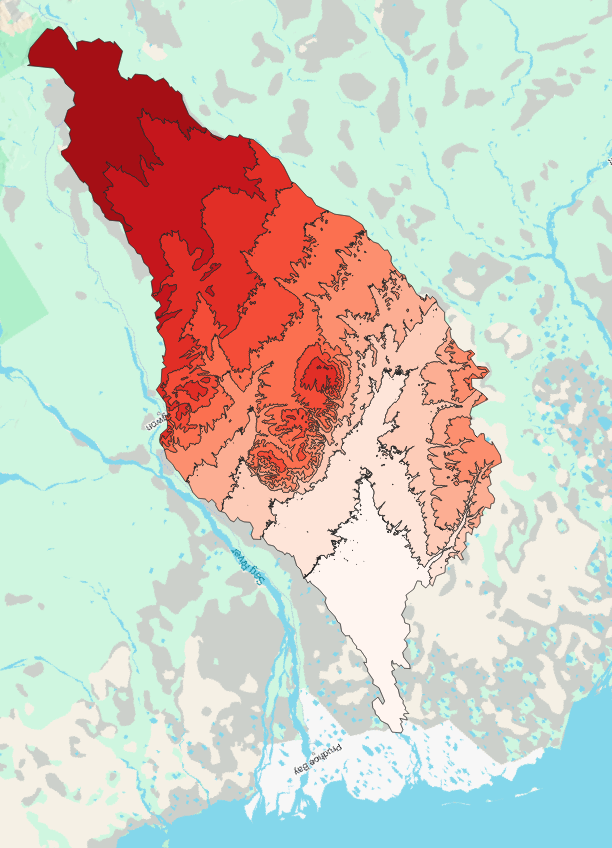

In [12]:
display(HTML(display_image_gh_notebook('5A-kuparuk-topounits-elevationbins.PNG')))

Darker reds are higher elevation Topounits. We see that we have 10 different colors here, each with approximately the same area. We also see that the edges of these Topunits are kind of noisy:


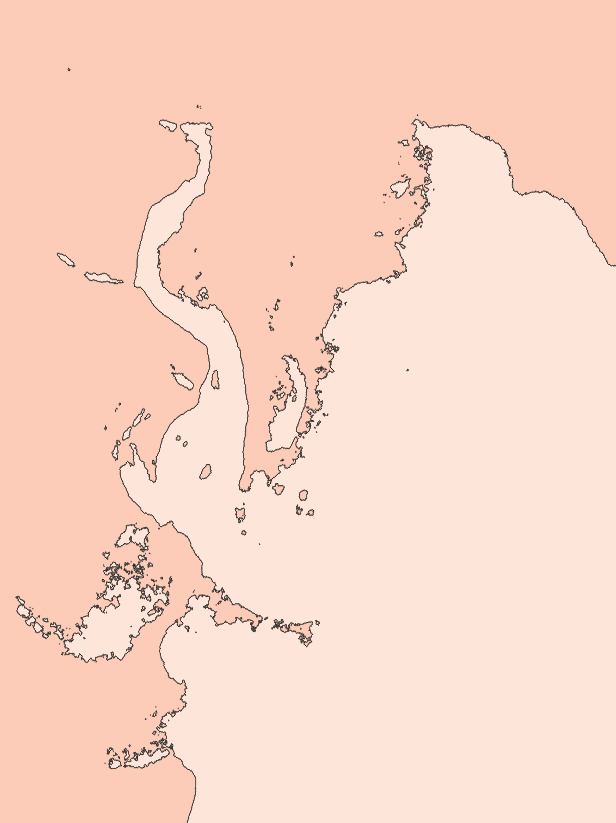

In [13]:
display(HTML(display_image_gh_notebook('5A-kuparuk-topounits-elevationbins-zoom.PNG')))

This "noise" isn't actually noise in the sense of random error, but it's due to the fact that I selected 2 meters as my export scale. As we choose larger export scales, our boundaries will become smoother. You may or may not care about the "noise", but it's good to know how to control it just in case.

Ok, let's move on to making Topounits that consider elevation *and* aspect.

### B. Generating Topounits for the Kuparuk watershed with elevation bins and aspect

This example is really similar to `A`, except we need to define an aspect range and specify some of the `make_topounits` parameters a little differently.

In [15]:
# We will use a new "method" for computing Topounits
method = 'elevaspect' # specifies we want to use percentiles of elevation to define the Topounits

# We also need to provide aspect ranges to use. These are in the form (start, end, label).
# Here, let's consider only North and South. So evertyhing from 270 (West) to 90 (East) will be North,
# and everything from 90 (East) to 270 (West) will be South. This assumes that we move around the 
# compass in a clockwise direction. Our aspect ranges therefore look like this:
aspect_ranges = [(270, 90, 'N'), (90.01, 269.99, 'S')]

# All the other parameters are the same
feature = ee.Feature(ee.FeatureCollection('projects/ee-jonschwenk/assets/E3SM/Kuparuk_gageshed').first())
n_elev_bins = 10 # number of bins to use; for this method corresponds to the number of Topounits
dem_source = 'arcticdem' # this is the default, but putting it here so you know we're using the ArcticDEM to do the binning
return_as = 'gdf' # specifies we want the Topounits to be returned as a GeoDataFrame; we could also choose "asset" to have them exported to our Google Drive
export_scale = 500 # in meters. This is a big watershed, so using pixels of 500 square meters should be a nice balance

topounits = tu.make_topounits(feature, 
                              method = method, 
                              n_elev_bins = n_elev_bins, 
                              dem_source = dem_source, 
                              return_as = return_as,
                              export_scale = export_scale,
                              aspect_ranges = aspect_ranges, # Note we added this
                              verbose = True) # So we get information about what's going on)

ValueError: 20 topounits exceed max of 11.

I intentionally chose this arrangement to demonstrate something you need to consider. Right now, the maximum number of Topounits that can be defined for a single grid cell is `11`. This is an E3SM constraint that `dapper` builds in by default. You can change this maximum by specifying `max_topounits` when calling `make_topounits`. However, let's respect the 11 here and figure out what went wrong. We asked for 10 elevation bins, and two aspect bins. Each elevation bin will be broken up into the aspect bins, so we've requested 10 (elevation bins) * 2 (aspect bins) which equals 20 Topounits, which is greater than 11. Let's adjust our parameters to make sure that the total number of Topounits does not exceed 11.

In [ ]:
# Let's reduce the number of elevation bins to 5, so we end up with 10 total Topounits
n_elev_bins = 5 # number of bins to use; for this method corresponds to the number of Topounits
export_scale = 50 # just for fun
topounits = tu.make_topounits(feature, 
                              method = method, 
                              n_elev_bins = n_elev_bins, 
                              dem_source = dem_source, 
                              return_as = return_as,
                              export_scale = export_scale,
                              aspect_ranges = aspect_ranges, # Note we added this
                              verbose = True) # So we get information about what's going on

Using scale of 1317.3008196800217 m for sampling elevations.
Success! FeatureCollection loaded as GeoDataFrame.


Great, it worked. Let's look at these Topounits in a GIS.


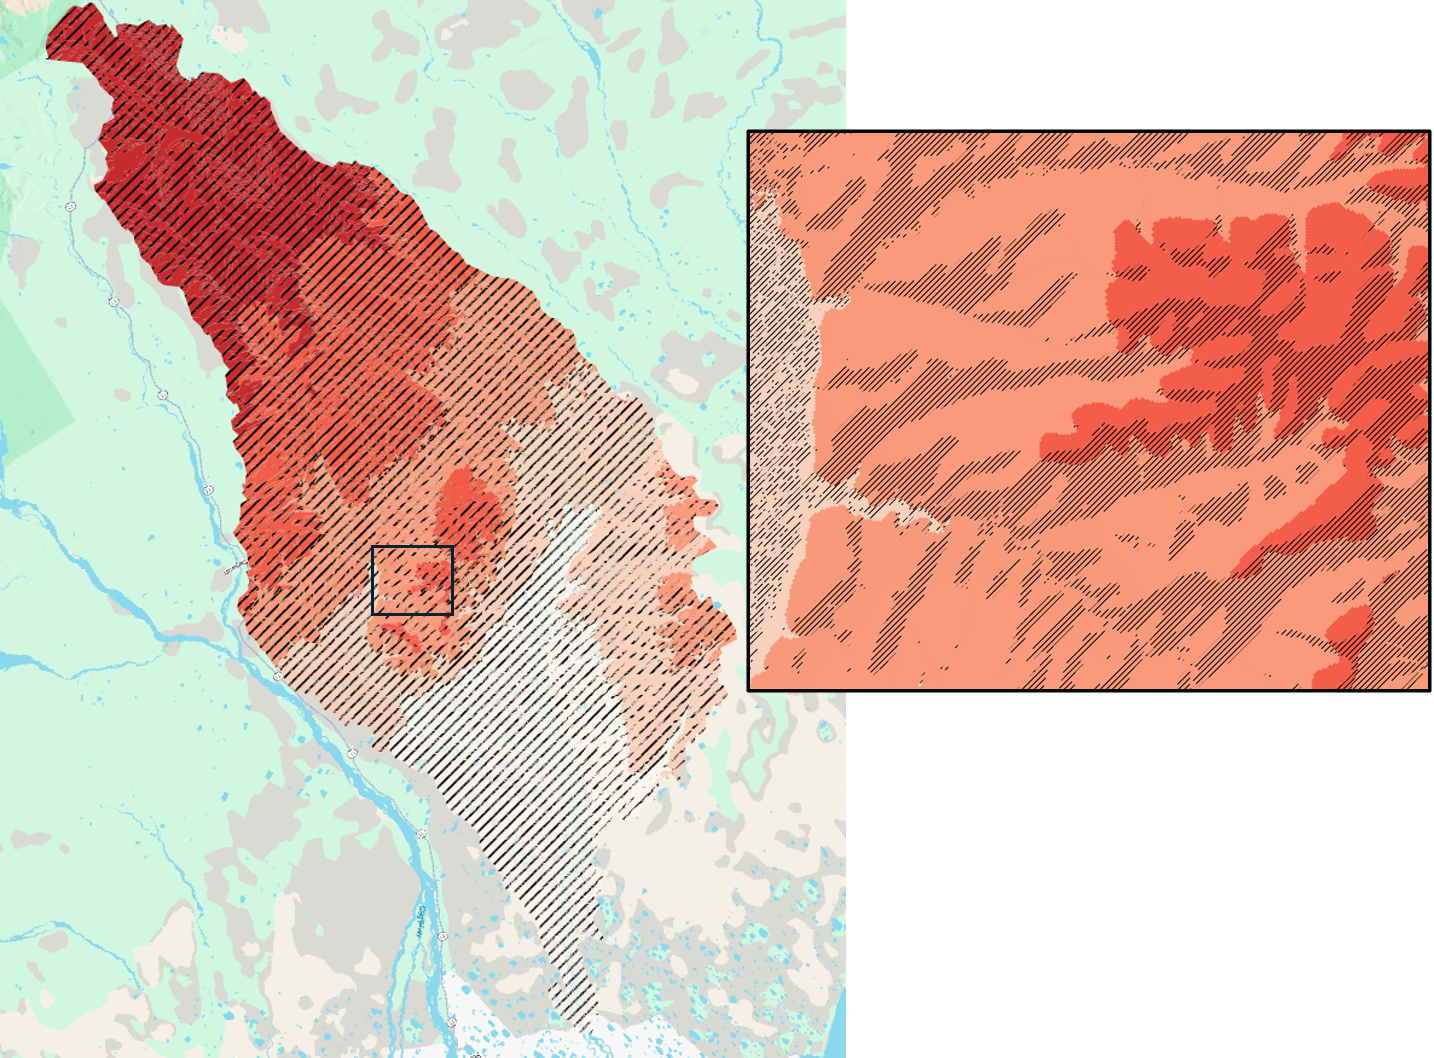

In [21]:
display(HTML(display_image_gh_notebook('5B-kuparuk-elevaspect-wzoom.PNG')))

The above image contains 10 total Topounits. The five red colors distinguish the elevation bins, while the black lines show topounits that are predominately North facing. A zoom view is shown to illustrate the spatial heterogeneity of Topounits. Areas without hashing represent predominately South facing slopes. You can see from the left plot that the watershed predominately faces North, but there are definitely some South-ish faces. Note that while elevation binning puts the same amount of area in each bin (so each Topounit is about the same size), aspect binning must adhere to the actual aspect distribution so you can end up with very unbalanced (in terms of area) Topounits. This might not matter for your application, but it's good to be aware.

### C. Generating Topounits for 0.5 degree grid cells


Here we want to consider the case where our domains are not watersheds, as it will highlight some differences. We'll create four 0.5 x 0.5 degree grid cells and delineate some Topounits for them.

In [ ]:
# Define a top-left coordinate
lat = 68.5
lon = -149.5
degrees_per_cell = 0.5
n_steps = 2 # how many steps in each dimension (2x2=4 total grid cells)

# Construct the polygons. 
polygons = []
for i in range(n_steps):
    for j in range(n_steps):
        minx = lon + j * degrees_per_cell
        maxx = minx + degrees_per_cell
        maxy = lat - i * degrees_per_cell
        miny = maxy - degrees_per_cell
        polygons.append(box(minx, miny, maxx, maxy))

# Put the cells in a GeoDataFrame and assign the CRS
gdf = gpd.GeoDataFrame(geometry=polygons, crs="EPSG:4326")
gdf['gid'] = [0,1,2,3] # Assign an id so we can keep track of the grid cells

Now we have our grid cells, we can make Topounits as we did in A and B. For this example, I'll choose three elevation bins and four aspect bins. Note that this equates to 12 Topounits per grid cell, so we'll need to update the `max_topounits` parameter to allow suprassing the default of 12.

In [ ]:
method = 'elevaspect' 
aspect_ranges = [
    (315, 45, 'N'),     # wraps around 0°, centered on 0° (North)
    (45, 135, 'E'),     # centered on 90° (East)
    (135, 225, 'S'),    # centered on 180° (South)
    (225, 315, 'W')     # centered on 270° (West)
]
n_elev_bins = 3 # number of bins to use; for this method corresponds to the number of Topounits
dem_source = 'arcticdem' # this is the default, but putting it here so you know we're using the ArcticDEM to do the binning
return_as = 'gdf' # specifies we want the Topounits to be returned as a GeoDataFrame; we could also choose "asset" to have them exported to our Google Drive
export_scale = 500 # in meters. This is a big watershed, so using pixels of 500 square meters should be a nice balance
max_topounits = 12 # need to include this now!

tus = {} # storage for our Topounit gdfs
# Loop through each grid cell and compute Topounits
for _, row in gdf.iterrows():
    this_feature = ee.Feature(gu.parse_geometry_object(row['geometry'], row['gid']).first()) # This is awkward and might change later
    print(f"Processing grid cell {row['gid']}...")
    tus[row['gid']] = tu.make_topounits(this_feature, 
                              method = method, 
                              n_elev_bins = n_elev_bins, 
                              dem_source = dem_source, 
                              return_as = return_as,
                              export_scale = export_scale,
                              aspect_ranges = aspect_ranges,
                              max_topounits = max_topounits,
                              verbose = True) # So we get information about what's going on
    
# Now we combine the grid cells into a single GeoDataFrame, adding a 'gid' column to keep track of which geometries come from which grid cell
gdf_combined = gpd.GeoDataFrame(
    pd.concat(
        [df.assign(gid=gid) for gid, df in tus.items()],
        ignore_index=True
    ),
    crs=next(iter(tus.values())).crs)  # inherit CRS from any gdf

# Export (set your path as you want)
gdf_combined.to_file(r'X:\Research\NGEE Arctic\6. Topounits\four_grid_cells.gpkg')


Processing grid cell 0...
Using scale of 436.92282313300177 m for sampling elevations.
Success! FeatureCollection loaded as GeoDataFrame.
Processing grid cell 1...
Using scale of 436.92282313299023 m for sampling elevations.
Success! FeatureCollection loaded as GeoDataFrame.
Processing grid cell 2...
Using scale of 441.6672291277392 m for sampling elevations.
Success! FeatureCollection loaded as GeoDataFrame.
Processing grid cell 3...
Using scale of 441.6672291277283 m for sampling elevations.
Success! FeatureCollection loaded as GeoDataFrame.



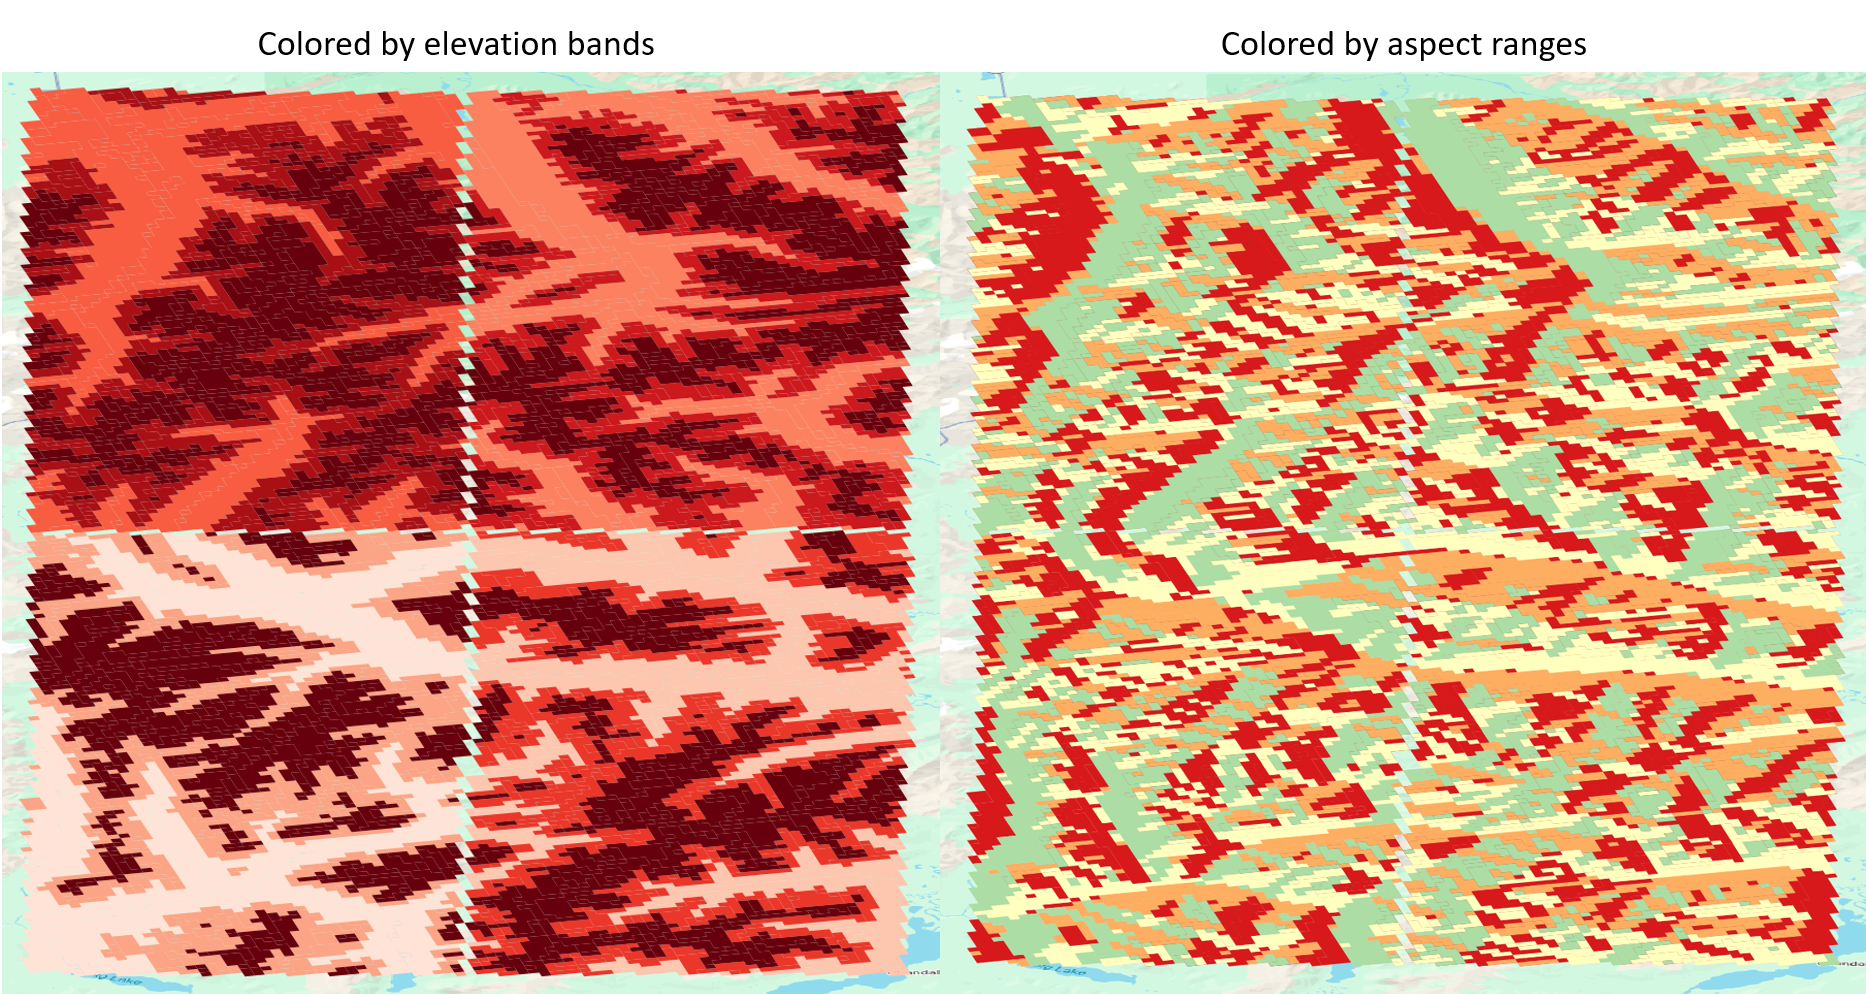

In [53]:
display(HTML(display_image_gh_notebook('5C-elevation-aspect-4gridcells.PNG')))

I struggled to figure out how to plot these and show both the elevation and aspect differences, so I just broke them out in the above images. Some things to note about these results: 
- Because we ran each grid cell individually, the elevation ranges are different for each one (but there are only 3 ranges in each cell)
- I used a low resolution export for speed--these could look much more "realistic" if we chose a smaller scale
- There are gaps between the grid cells that were not covered by Topounits. These can be closed in a number of ways, depending on what you're doing. If you want to keep the same processing technique we used here (4 separate calls to `make_topounits`), you could buffer the grid cells a little, then clip the Topounits on the back end. If you are OK with one call to `make_topounits`, you can just do the entire domain, then separate it into the constituent grid cells on the back end.
  
Below is an image of all the Topounits, colored by `topounit_id` (there are 12 ids for each grid cell). Remember that `topounit_id=1`  *is not the same* for all four grid cells because the elevation bands were recomputed for each grid cell.


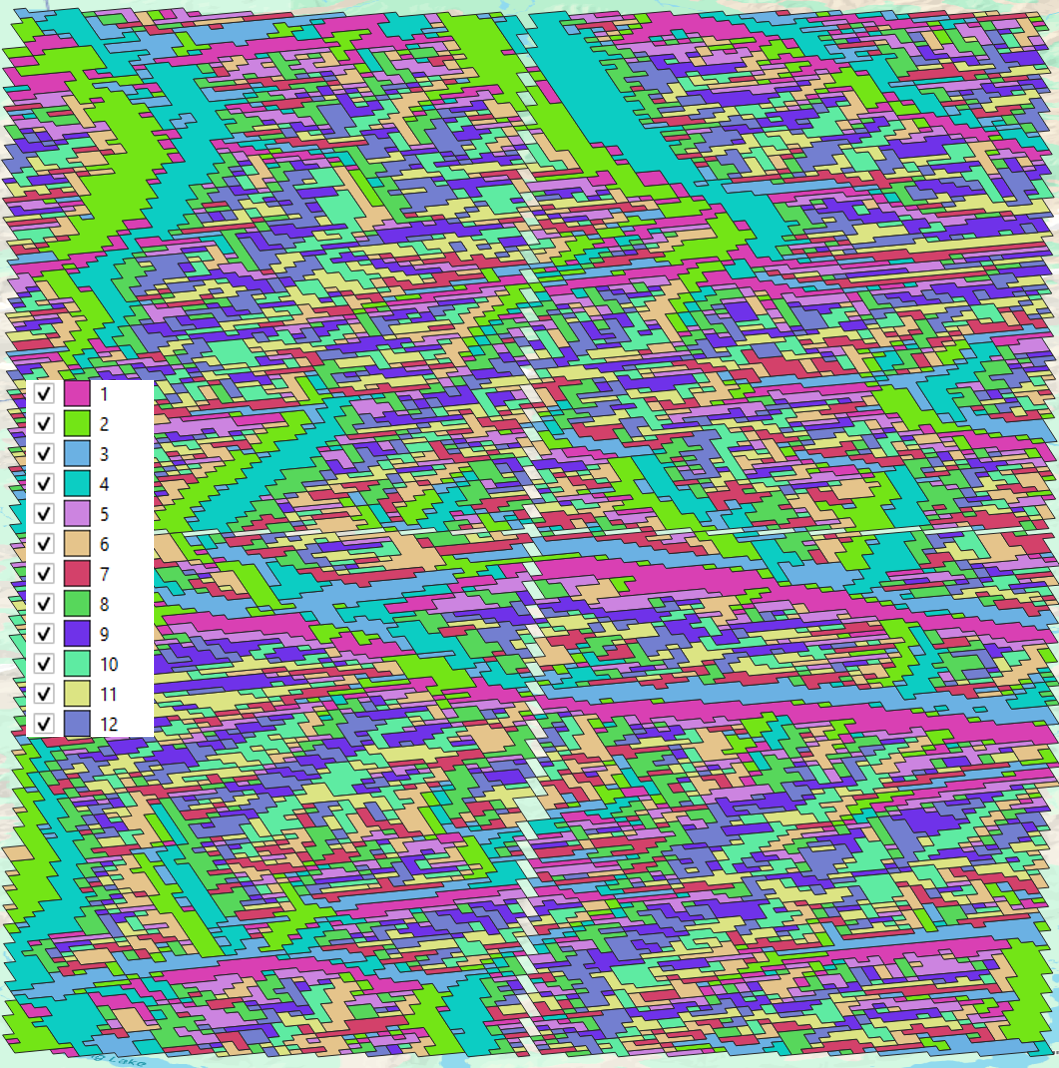

In [55]:
display(HTML(display_image_gh_notebook('5C-all-topounits-4gridcells.PNG')))

Below is an image of the properties table of the Topounit GeoDataFrame we exported to show you that each Topounit has all the properties needed to identify which elevantion bin and/or aspect range it represents.


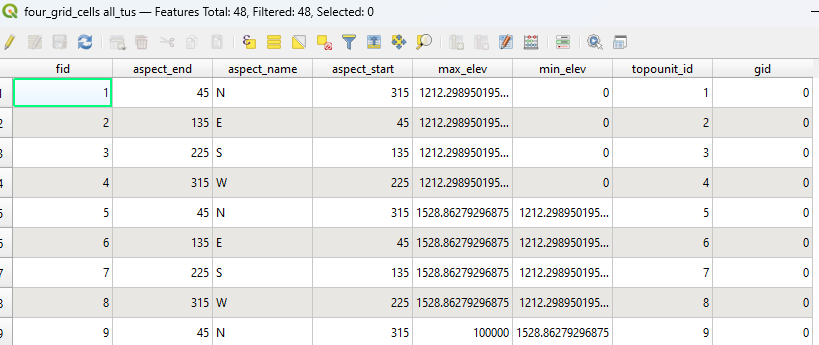

In [56]:
display(HTML(display_image_gh_notebook('5C-topounit-attribute-table.PNG')))